**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: Tara Boyle and Patrick Stewart en www.towardsdatascience.com. Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# 07: Datos desbalanceados

There are many different datasets where there is a clear dominance in some types of data instances (known as majority classes) with other types significantly underrepresented (minority classes). This has significant implications for the practice of data science, where simply training a model on a dataset with this characteristic will likely lead to bias towards the majority classes. 

### The problem characteristics of imbalanced datasets

Firstly, it is important to understand why imbalanced datasets are a crucial problem that needs to be addressed. We can do this by looking at this with respect to key data issues:

* Small disjuncts. The small disjuncts problem occurs when there are clusters of the dataset which have a much higher misclassification rate than the overall rate. This is problematic for divide-and-conquer centred algorithms such as decision trees where certain instance types, namely those with a minority class are likely to have a very poor classification performance.

* Lack of density. There is a lack of information about some classes. Induction algorithms do not have enough data to make generalizations about the distribution of samples, with minority classes most at risk of being misrepresented in the model.

* Noisy data. presence of noise in the dataset has a greater impact on the minority classes than on the other classes. Noise will impact the minority classes to a greater extent, significantly impacting the model.

* Dataset shift. this occurs when the training and test datasets follow different distributions. This is a common issue and affects all sorts of categorization problems, often as a result of sample selection bias. With highly imbalanced datasets, the minority class is particularly sensitive to classification errors and therefore is impacted by the shift to a greater extent.

Data led techniques aim to reduce the skew in the ratio between the underrepresented and overrepresented classes by either increasing the representation of the minority classes (oversampling) or reducing the representation of the majority classes (undersampling) in a transformed dataset, which models can be successfully trained on. The figure below gives a more exhaustive list of the various techniques that can be used, however in this article we focus on three of the most commonly used techniques; random oversampling, random undersampling and SMOTE.

![imbalance](https://miro.medium.com/max/1252/1*qLEDoVvVqYpSlvdYV-n9bQ.png)

Inicialmente se importan las librarías a utilizar

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from pandas import DataFrame
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter("ignore")

En este caso vamos a importar los datos y crear el dataframe para un problema de clasificación para evaluar la susceptibilidad por movimientos en masa.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
driver = gdal.GetDriverByName('GTiff')
file = gdal.Open(r'/content/drive/MyDrive/CATEDRA/CARTOGRAFIA GEOTECNICA/cartoGeotecnia_book/_build/html/data/miel/Pendiente.tif')
pendiente = file.GetRasterBand(1)
pendiente = pendiente.ReadAsArray()
pendiente=np.where(pendiente<0,np.nan,pendiente)
pendiente_vector=pendiente.ravel()
pendiente_vector2=np.nan_to_num(pendiente_vector)
pendiente_vector_MenM=pendiente_vector[~np.isnan(pendiente_vector)] # para eliminar  del vector los datos inf
print(pendiente_vector_MenM.shape)

raster = gdal.Open(r'/content/drive/MyDrive/CATEDRA/CARTOGRAFIA GEOTECNICA/cartoGeotecnia_book/_build/html/data/miel/CurvaturaPlana.tif')
curvatura=raster.GetRasterBand(1)
curvatura=curvatura.ReadAsArray()
curvatura=np.where(curvatura<0,np.nan,curvatura)
curvatura_vector=curvatura.ravel()
curvatura_vector2=np.nan_to_num(curvatura_vector)
curvatura_vector_MenM=curvatura_vector[~np.isnan(curvatura_vector)]
print(curvatura_vector_MenM.shape)

raster = gdal.Open(r'/content/drive/MyDrive/CATEDRA/CARTOGRAFIA GEOTECNICA/cartoGeotecnia_book/_build/html/data/miel/Aspecto.tif')
aspecto=raster.GetRasterBand(1)
aspecto=aspecto.ReadAsArray()
aspecto=np.where(aspecto==-999.,np.nan,aspecto)
aspecto_vector=aspecto.ravel()
aspecto_vector2=np.nan_to_num(aspecto_vector)
aspecto_vector_MenM=aspecto_vector[~np.isnan(aspecto_vector)]
print(aspecto_vector_MenM.shape)

raster = gdal.Open(r'/content/drive/MyDrive/CATEDRA/CARTOGRAFIA GEOTECNICA/cartoGeotecnia_book/_build/html/data/miel/FlujoAcumulado.tif')
flujo=raster.GetRasterBand(1)
flujo=flujo.ReadAsArray()
flujo=np.where(flujo<0,np.nan,flujo)
flujo_vector=flujo.ravel()
flujo_vector2=np.nan_to_num(flujo_vector)
flujo_vector_MenM=flujo_vector[~np.isnan(flujo_vector)]
print(flujo_vector_MenM.shape)

driver = gdal.GetDriverByName('GTiff')
file = gdal.Open(r'/content/drive/MyDrive/CATEDRA/CARTOGRAFIA GEOTECNICA/cartoGeotecnia_book/_build/html/data/miel/Geologia_Superficial.tif')
band = file.GetRasterBand(1)
geologia = band.ReadAsArray()
geologia=np.where(geologia<0,np.nan,geologia)
geologia_vector=geologia.ravel()
geologia_vector2=np.nan_to_num(geologia_vector)
geologia_vector_MenM=geologia_vector[~np.isnan(geologia_vector)]
print(geologia_vector_MenM.shape)


(910801,)
(910801,)
(910801,)
(910801,)
(910801,)
(910801,)


In [31]:
raster = gdal.Open(r'/content/drive/MyDrive/CATEDRA/CARTOGRAFIA GEOTECNICA/cartoGeotecnia_book/_build/html/data/miel/Inventario_MenM.tif')
inventario=raster.GetRasterBand(1)
inventario=inventario.ReadAsArray()
msk=np.where(pendiente>=0,1,np.nan)
inventario=msk*inventario
inventario_vector=inventario.ravel()
inventario_vector_MenM=inventario_vector[~np.isnan(inventario_vector)]
print(inventario_vector_MenM.shape)

(910801,)


array([ 0., nan])

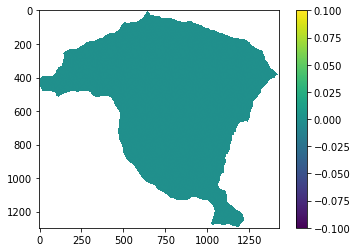

In [30]:
plt.imshow(inventario)
plt.colorbar()

In [32]:
d={'inventario':inventario_vector_MenM,'cobertura':geologia_vector_MenM,'pendiente':pendiente_vector_MenM,'flujo_acum':flujo_vector_MenM,'aspecto':aspecto_vector_MenM,
   'curvatura':curvatura_vector_MenM}
x = pd.DataFrame(d)
X=x.drop(['inventario'],axis=1)
y=x['inventario']

Con la base de datos de las variables independientes (X) y de la variable dependiente (y), se puede evalaur si estamo ante un problema de datos desbalanceados.

In [33]:
y.value_counts()

0.0    909181
1.0      1620
Name: inventario, dtype: int64

In [34]:
from collections import Counter
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0.0: 909181, 1.0: 1620})


La clase con valor 1 solo representa el 2.7% de las observaciones, y precisamente dicha clase, al ser la ocurrencia de movimientos en masa, representa la clase con la mayor relevancia en el entrenamiento.

A continuación se utilizará el modelo de regresión logística. Incialmente se utilizarán los datos actuales para conocer el ajuste del modelo ante un entrenamiento con datos desbalanceados.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
lr=LogisticRegression()
results = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print(results)
print(results.mean())
print(results.std())

[0.99821402 0.9982067  0.9982067  0.9982067  0.9982067 ]
0.9982081686429514
2.9278290147871644e-06


Se observa una excelente ajuste (*accuracy*) del 97%. Si evaluamos la matriz de confusión:

In [43]:
# setting up testing and training sets
lr=LogisticRegression(class_weight='balanced')
results = cross_val_score(lr, X_train, y_train, cv=5, scoring='recall')
print(results)
print(results.mean())
print(results.std())

[0.57786885 0.63265306 0.64897959 0.68163265 0.65306122]
0.6388390766142522
0.03432790335641302


In [44]:
model=lr.fit(X_train, y_train)

In [45]:
y_test_pred=model.predict(X_test)

In [46]:
y_test_pred

array([1., 0., 0., ..., 0., 0., 0.])

In [47]:
mc= confusion_matrix(y_test, y_test_pred)
print(mc)

[[138272  89033]
 [   139    257]]


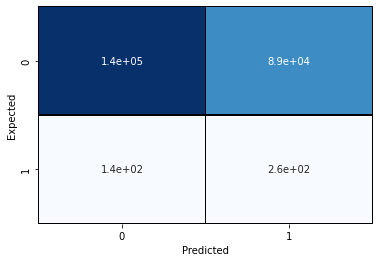

In [48]:
matrix = confusion_matrix(y_test, y_test_pred)
import seaborn as sns
sns.heatmap(matrix, annot=True, cbar=False, linecolor='black',linewidths=0.7,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Se observa que el modelo se entrenó muy bien para las celdas de la clase 0, no movimientos en masa, y al ser esta clase la mayoría de celdas pues genera un alto valor de verdaderos negativos, sin embargo no encontró ni una celda de la clase 1, y un número importante de falsos negativos.

A continuación se utilizará la función *imblearn* para sub-muestrear la clase que tiene mas valores (0).

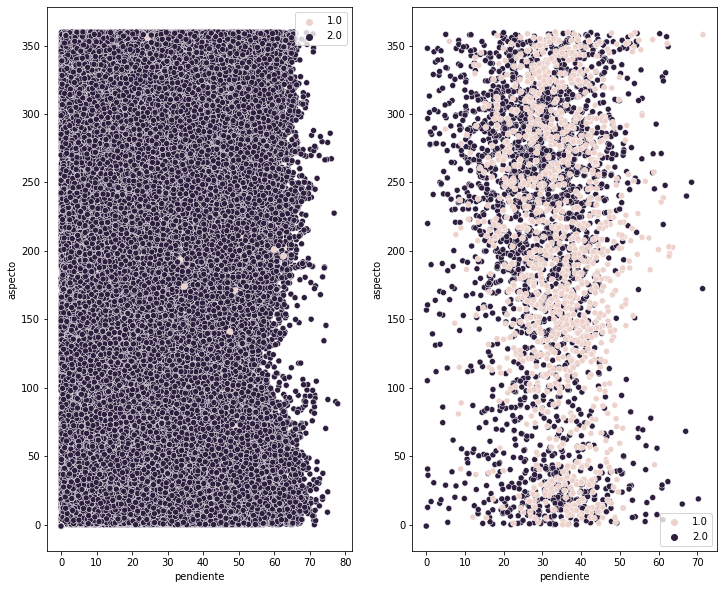

In [50]:
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler(sampling_strategy=0.5)
X_rus,y_rus=rus.fit_resample(X_train,y_train)
y_t= np.where(y_train==0,2,y_train)
y_r= np.where(y_rus==0,2,y_rus)
f, axes = plt.subplots(1, 2, figsize=(12,10))
sns.scatterplot(X_train['pendiente'],X_train['aspecto'],hue=y_t,ax=axes[0]);
sns.scatterplot(X_rus['pendiente'],X_rus['aspecto'],hue=y_r,ax=axes[1]);

In [51]:
model_rus=LogisticRegression().fit(X_rus,y_rus)
y_test_pred=model_rus.predict(X_test)
mc= confusion_matrix(y_test, y_test_pred)
print(Counter(y_test_pred))
print(mc)

Counter({0.0: 208654, 1.0: 19047})
[[208339  18966]
 [   315     81]]


Como se observa, se reduce considerablemente el *accuracy* del modelo. En cuanto a la matriz de confusión:

Se reducen los verdaderos negativos, pero el modelo ya identifica un número importante de verdaderos positivos (675). Pero genera al mismo tiempo un gran número de falsos positivos, lo cual puede señalar un problema de *bias*

A continuación se implementa el mismo modelo de regresión logística, pero con un sobremuestreo de la clase minoritaria.

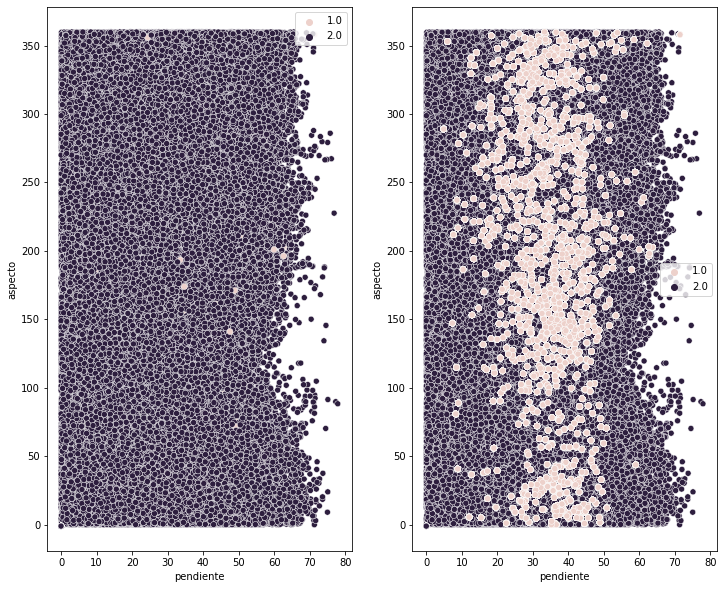

In [53]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler()
X_ros,y_ros=ros.fit_resample(X_train,y_train)
y_r= np.where(y_ros==0,2,y_ros)

f, axes = plt.subplots(1, 2, figsize=(12,10))
sns.scatterplot(X_train['pendiente'],X_train['aspecto'],hue=y_t,ax=axes[0]);
sns.scatterplot(X_ros['pendiente'],X_ros['aspecto'],hue=y_r,ax=axes[1]);

In [54]:
model_ros=LogisticRegression().fit(X_ros,y_ros)
y_test_pred=model_ros.predict(X_test)
mc= confusion_matrix(y_test, y_test_pred)
print(Counter(y_test_pred))
print(mc)

Counter({0.0: 138383, 1.0: 89318})
[[138244  89061]
 [   139    257]]


Se observan resultados similares que el modelo de submuestreo, al igual que el caso siguiente donde se implementa la función  Synthetic minority oversampling technique *SMOTE*. SMOTE works by choosing an instance in the minority class at random. Then the k-nearest neighbours of that instance is found (e.g. knn = 5), with one of these nearest neighbours selected at random. From this a new synthetic instance is created as a convex combination of the target datapoint and target chosen nearest neighbour datapoint.

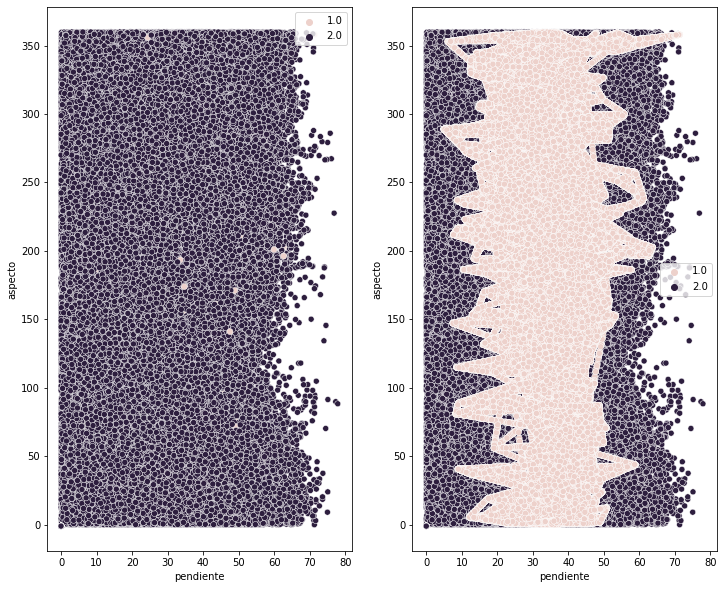

In [56]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train, y_train)
y_sm1= np.where(y_sm==0,2,y_sm)
f, axes = plt.subplots(1, 2, figsize=(12,10))
sns.scatterplot(X_train['pendiente'],X_train['aspecto'],hue=y_t, ax=axes[0]);
sns.scatterplot(X_sm['pendiente'],X_sm['aspecto'],hue=y_sm1,ax=axes[1]);

In [57]:
model=LogisticRegression().fit(X_sm,y_sm)
y_test_pred=model.predict(X_test)
mc= confusion_matrix(y_test, y_test_pred)
print(Counter(y_test_pred))
print(mc)

Counter({0.0: 138696, 1.0: 89005})
[[138559  88746]
 [   137    259]]


There are two hyperparameters:

* k_neighbours: represents number of nearest to be consider while generating synthetic points.

* sampling_strategy: by default generates synthetic points equal to number of points in majority class. Since, here it is 0.5 it will generate synthetic points half of that of majority class points.